In [3]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
#from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels, SvmDesionTree2
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral
import tables as ta
from sklearn.decomposition import PCA

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2288.0_x64__qbz5n2kfra8p0\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [4]:
#Indian pines dataset laod 
indian_pines_gt = sc.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines_gt.mat")
indian_pines = sc.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines_corrected.mat")

indian_pines = indian_pines["indian_pines_corrected"]
indian_pines_gt = indian_pines_gt["indian_pines_gt"]

In [6]:
pL = copy.deepcopy(indian_pines_gt)
pL_train = np.zeros((145,145), dtype=np.int8)
pL_test = np.zeros((145,145), dtype=np.int8)
proportion = 0.05
for i in range(1, 17):
    print(np.sum((pL==i)),np.int16(np.ceil(np.sum((pL==i))*.1)))
    ikeep = np.int16(np.ceil(np.sum((pL==i))*proportion))
    #ikeepa = np.int16(np.ceil(np.sum((pL==i))*proportion))
    pL_load = np.zeros(len(pL_train[pL == i]), dtype=np.int16)
    pL_load[:ikeep] = i
    pL_load[-ikeep:] = i
    pL_train[pL == i] = pL_load[:]
    pL_load -= i
    pL_load = np.abs(pL_load)
    pL_test[pL == i] = pL_load[:]

46 5
1428 143
830 83
237 24
483 49
730 73
28 3
478 48
20 2
972 98
2455 246
593 60
205 21
1265 127
386 39
93 10


In [16]:
X = indian_pines.reshape(145*145, 200)
y = indian_pines_gt.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.95, stratify=y )


nComp = 3
pca = PCA(n_components=nComp)
pca.fit(X_train)
pcX_train = pca.transform(X_train)

pcX = pca.transform(X)

In [17]:
linear_yout, rbf_yout = SingleSVMTest(pcX,y,pcX, pL_train.flatten(),1e2)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear Training Time: 0.169sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF Training Time: 0.898sec.
Linear Predict Time: 0.136sec.
RBF Predict Time: 3.623sec.
Linear Accuracy: 17.5%
RBF Accuracy: 24.7%
Linear Total SVM Support_Vectors : 330
RBF Total SVM Support_Vectors : 2325
Linear Avarage SVM Support_Vectors : 19.412
RBF Average SVM Support_Vectors : 136.765


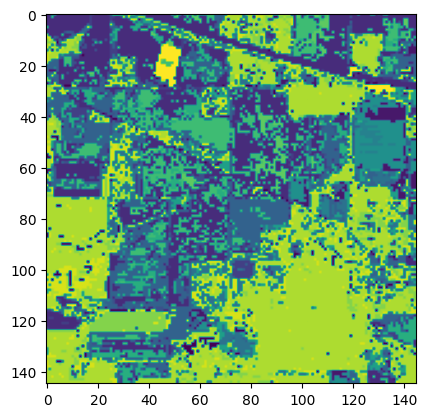

In [18]:
shape = int(np.sqrt(len(linear_yout)))
plt.imshow(linear_yout.reshape(shape, shape))

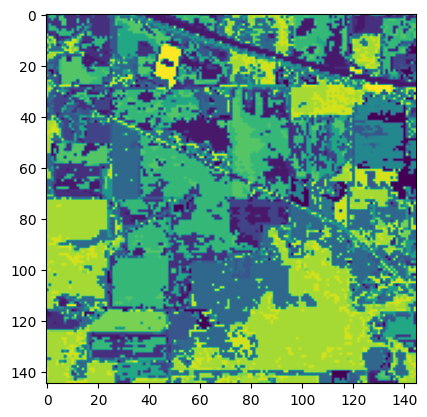

In [19]:
shape = int(np.sqrt(len(rbf_yout)))
plt.imshow(rbf_yout.reshape(shape, shape))

In [51]:
tb = {0 : [[2,11,14],[0,1,3,4,5,6,7,8,9,10,12,13,15,16]], 
    1 : [[[2],[11,14]],[[0],[12,1,3,4,5,6,7,8,9,10,13,15,16]]],
    2 : [[[11],[14]],[[15],[12,1,3,4,5,6,7,8,9,10,13,16]]],
    3 : [[],[[1],[12,3,4,5,6,7,8,9,10,13,16]]],
    4 : [[],[[1],[3,4,5,6,7,8,9,10,13,16]]],
    5 : [[],[[3],[4,5,6,7,8,9,10,13,16]]],
    6 : [[],[[4],[5,6,7,8,9,10,13,16]]], 
    7 : [[],[[5],[6,7,8,9,10,13,16]]],
    8 : [[],[[6],[7,8,9,10,13,16]]],
    9 : [[],[[7],[8,9,10,13,16]]],
    10 : [[],[[8],[9,10,13,16]]],
    11 : [[],[[9],[10,13,16]]],
    12 : [[],[[10],[13,16]]],
    13 : [[],[[13],[16]]],
    }
    
iter = 1e6

svmb = {0 : SVC(kernel="linear", class_weight= "balanced", max_iter=iter, decision_function_shape="ovo"), 
        1 : [SVC(kernel="linear",class_weight= "balanced", max_iter=iter, decision_function_shape="ovo"),SVC(kernel="linear",class_weight= "balanced", max_iter=iter, decision_function_shape="ovo")],
        2 : [SVC(kernel="linear",class_weight= "balanced", max_iter=iter,decision_function_shape="ovo"),SVC(kernel="linear",class_weight= "balanced", max_iter=iter,decision_function_shape="ovo")],
        3 : [False ,SVC(kernel="linear",class_weight= "balanced", decision_function_shape="ovo", max_iter=iter)],
        4 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        5 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        6 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)], 
        7 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        8 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        9 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        10 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        11 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        12 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
        13 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)],
}

svm_tree_branches = SvmDesionTreeTrain(pcX, pL_train.flatten(), tb, svmb)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSo

The training time is: 117.165 sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [52]:
classesSvmBranches(svm_tree_branches)

[array([0, 2], dtype=int8),
 [array([ 2, 11], dtype=int8), array([0, 1], dtype=int8)],
 [array([11, 14], dtype=int8), array([ 1, 15], dtype=int8)],
 [array([1, 3], dtype=int8)],
 [array([1, 3], dtype=int8)],
 [array([3, 4], dtype=int8)],
 [array([4, 5], dtype=int8)],
 [array([5, 6], dtype=int8)],
 [array([6, 7], dtype=int8)],
 [array([7, 8], dtype=int8)],
 [array([8, 9], dtype=int8)],
 [array([ 9, 10], dtype=int8)],
 [array([10, 13], dtype=int8)],
 [array([13, 16], dtype=int8)]]

In [53]:
predicted_label = SvmDesionTreePredict(pcX, svm_tree_branches, tb)

C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:246: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:255: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


The prediction time is: 0.446 sec.


In [54]:
classesInLabels(predicted_label)

array([ 0,  1,  2, 11, 15], dtype=int8)

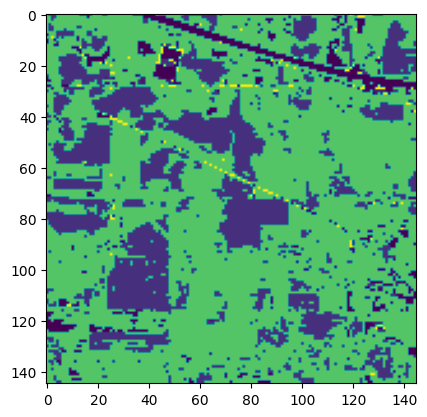

In [55]:
shape = int(np.sqrt(len(predicted_label)))
plt.imshow(predicted_label.reshape(shape, shape))

In [23]:
tb1 = {0: [[15,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,14]], 1 : [[[15],[16]],[[14],[1,2,3,4,5,6,7,8,9,10,11,12,13]]]} #2 : [[],[[1,2,3,4,8,9,10,11,12,13],[5,6,7]]]}
tb2 = {0 : [[1,2,3,4,8,9,10,11,12,13],[5,6,7]], 1 : [[[8],[1,2,3,4,9,10,11,12,13]],[[5],[6,7]]], 2: [[],[[6],[7]]]}
tb3 = {0 : [[10,11,12,13],[1,2,3,4,9]], 1 : [[[13],[10,11,12]],[[1],[2,3,4,9]]], 2 : [[[10],[11,12]],[[2],[3,4,9]]], 3 : [[[11],[12]],[[4],[3,9]]], 4 : [[],[[3],[9]]]}

iter = 1e4
svm = SVC(kernel="linear", class_weight= "balanced", max_iter=iter)
svm = LinearSVC(class_weight= "balanced", max_iter=iter)
svmb1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) , 
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
        2 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb2 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) ,
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb3 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter), 
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
        3 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}


"""

tb1 = {0: [[0,15,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,14]], 1 : [[[0],[15,16]],[[14],[1,2,3,4,5,6,7,8,9,10,11,12,13]]]} #2: [[[15],[16]],[]]}
tb2 = {0 : [[1,2,3,4,8,9,10,11,12,13],[5,6,7]], 1 : [[[8],[1,2,3,4,9,10,11,12,13]],[[5],[6,7]]], 2 : [[],[[6],[7]]]}
tb3 = {0 : [[10,11,12,13],[1,2,3,4,9]], 1 : [[[13],[10,11,12]],[[1],[2,3,4,9]]], 2 : [[[10],[11,12]],[[4],[2,3,9]]], 3 : [[[11],[12]],[[2],[3,9]]], 4 : [[],[[3],[9]]]}


tb1 = {0: [[8,15,16],[1,2,3,4,5,6,7,0,9,10,11,12,13,14]], 1 : [[[8],[15,16]],[[14],[1,2,3,4,5,6,7,0,9,10,11,12,13]]], 2: [[[15],[16]],[]]}
tb2 = {0 : [[1,2,3,4,0,9,10,11,12,13],[5,6,7]], 1 : [[[0],[1,2,3,4,9,10,11,12,13]],[[5],[6,7]]], 2 : [[],[[6],[7]]]}
tb3 = {0 : [[10,11,12,13],[1,2,3,4,9]], 1 : [[[13],[10,11,12]],[[1],[2,3,4,9]]], 2 : [[[10],[11,12]],[[4],[2,3,9]]], 3 : [[[11],[12]],[[2],[3,9]]], 4 : [[],[[3],[9]]]}

iter = 1e4

svmb1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter),
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), False] }

svmb2 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) ,
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
        2 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb3 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter), 
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
        3 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}
"""
"""
tb1 = {0 : [[2,6,7,8,9,10,15],[1,3,4,5,11,12,13,14,16]], 1 : [[[8],[2,6,7,9,10,15]],[[1],[3,4,5,11,12,13,14,16]]]}

tb2_0 = {0 : [[2,6,7],[9,10,15]], 1 : [[[2],[6,7]],[[9],[10,15]]], 2 : [[[6],[7]],[[10],[15]]]}

tb2_1 = {0 : [[3,4,5,11],[12,13,14,16]], 1 : [[[3],[4,5,11]],[[12],[13,14,16]]], 2 : [[[4],[5,11]],[[13],[14,16]]], 3 : [[[5],[11]],[[14],[16]]]}

iter = 1e6

svmb1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter), 1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb2_0 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter),
         1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
         2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]
          }

svmb2_1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter),
         1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
         2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
         3 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]
          }

"""
svm_tree_branches1, sub_data_branch1 = SvmDesionTreeTrain(pcX, pL_train.flatten(), tb1, svmb1, sub_data = 1)

sub_data2, sub_labels2 = RetrieveSubData(pcX, pL_train.flatten(), tb2[0])
svm_tree_branches2, sub_data_branch2 = SvmDesionTreeTrain(sub_data2, sub_labels2, tb2, svmb2, sub_data=1)

sub_data3, sub_labels3 = RetrieveSubData(pcX, pL_train.flatten(), tb3[0])
svm_tree_branches3, sub_data_branch3 = SvmDesionTreeTrain(sub_data3, sub_labels3, tb3, svmb3, sub_data=1)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The training time is: 0.341 sec.
The training time is: 0.17 sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear 

The training time is: 0.317 sec.


In [34]:
pl1, sd1, pbl1 = SvmDesionTreePredict(pcX, svm_tree_branches1, tb1, sub_data=1)

C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:246: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:255: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


The prediction time is: 0.195 sec.


In [35]:
pl2, sd2, pbl2 = SvmDesionTreePredict(sd1[1][0], svm_tree_branches2, tb2, sub_data=1)

The prediction time is: 0.08 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:246: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:255: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [36]:
pl3, sd3, pbl3 = SvmDesionTreePredict(sd2[1][0], svm_tree_branches3, tb3, sub_data=1)

The prediction time is: 0.017 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:246: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):


In [47]:
def combineMultiBranch(sub_branch_label,sub_branch, branch_label): 
    combined_sub_label = combineLabels(sub_branch_label, sub_branch)

    combined_label = copy.deepcopy(branch_label)
    count = 0

    for i in range(len(combined_label)): 
        if(count <= len(combined_sub_label)): 
            if(min(combined_sub_label) == combined_label[i]): 
                combined_label[i] = combined_sub_label[count]
                count = count + 1

    return combined_label

In [37]:
cmb3 = combineMultiBranch(pbl2, tb2, pbl2[1][0])
pbl2[1][0] = cmb3
cmb2 = combineMultiBranch(pbl3, tb3, pbl1[1][0])
pbl1[1][1] = cmb2
predicted_label = CombineLabels(pbl1, tb1)

C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:246: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_10048\2560446814.py:255: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [21]:
print(len(pl1))

21025


In [22]:
classesSvmBranches(svm_tree_branches3)
print(len(sd3[4][1]))

NameError: name 'sd3' is not defined

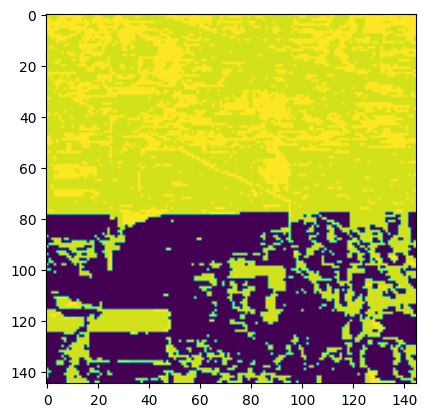

In [38]:
shape = int(np.sqrt(len(predicted_label)))
plt.imshow(predicted_label.reshape(shape, shape))

In [39]:
sum(predicted_label==y)/len(y)

0.01816884661117717

In [40]:
classesInLabels(predicted_label)

array([ 1, 15, 16], dtype=int8)

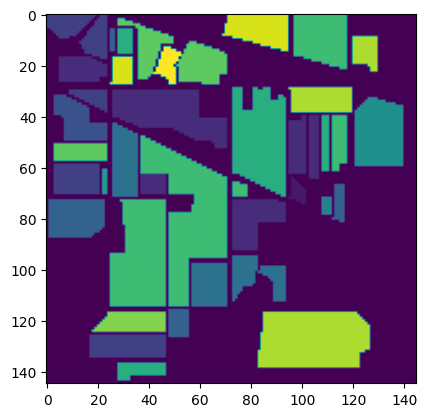

In [54]:
shape = int(np.sqrt(len(y)))
plt.imshow(y.reshape(shape, shape))

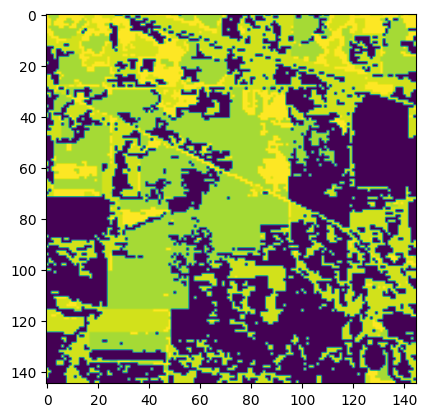

In [27]:
shape = int(np.sqrt(len(pl1)))
plt.imshow(pl1.reshape(shape, shape))

In [28]:
(pl1 == y).sum()/len(y)

0.016361474435196196